In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time, itertools

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    if x.ndim == 1:
        x = x.reshape(1, -1) # Convert 1D array to 2D array
    e_x = np.exp(x)
    return e_x / (np.sum(e_x, axis=1, keepdims=True) + 1e-16) # Add small value to avoid division by zero

def log_stable(x):
    """Compute log values for each sets of scores in x."""
    return np.log(x + np.exp(-16))

def calculate_shannon_entropy(p):
    """Calculate Shannon entropy of a probability distribution."""
    return -np.sum(p * log_stable(p))

def calculate_kl_divergence(q):
    """Calculate KL divergence between two probability distributions. In our case it is picking one valid configuration"""
    aggregate_post = np.sum(q, axis=0, keepdims=True)
    p = np.where(aggregate_post == np.max(aggregate_post), 1, 0)
    return np.sum(p * log_stable(p / (q + np.exp(-16))))/16 #Divide by 16 to normalize the KL divergence

# Define system dynamics
def system_dynamics(x, u, dt=1):
    return x + u * dt

# Define observation model
def observation_model(x):
    return x

def custom_cdist(x, goals, types):
    """
    Compute the pairwise distance between rows of x and rows of goals based on measurement types.
    """
    diff_to_goals = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
    distances_to_goals = np.linalg.norm(diff_to_goals, axis=2)
    angles_to_goal = np.arctan2(diff_to_goals[:, :, 1], diff_to_goals[:, :, 0])
    diff_to_robot = x[:, np.newaxis, :] - x[np.newaxis, :, :]
    angles_to_robot = np.arctan2(diff_to_robot[:, :, 1], diff_to_robot[:, :, 0])
    relative_angles = np.abs((angles_to_goal[np.newaxis, :, :] - angles_to_robot[:, :, np.newaxis] + np.pi) % (2 * np.pi) - np.pi)
    alignment = 1 - np.cos(relative_angles)
    return distances_to_goals

def calculate_joint_goal_probs(agent_poses, goals, predict_types, reward_configs, eta=5):
    num_agents = agent_poses.shape[0]
    num_goals = goals.shape[0]
    distances = custom_cdist(agent_poses, goals, predict_types)
    evidence = eta * np.exp(-1.0 / eta * distances)
    probabilities = softmax(evidence)
    joint_probabilities = np.ones([num_goals] * num_agents, dtype=float)
    for i in range(num_agents):
        joint_probabilities *= probabilities[i].reshape([num_goals if j == i else 1 for j in range(num_agents)])
    likelihood = np.array([joint_probabilities[tuple(config)] for config in reward_configs], dtype=np.float64)
    likelihood = softmax(likelihood)
    return likelihood, distances

def compute_distance(x, goals):
    diff = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    return distances

def compute_entropy(evidence, prior):
    likelihood = evidence
    posterior = softmax(likelihood * prior)
    entropy_cost = calculate_shannon_entropy(posterior)
    kl_cost = 2*calculate_kl_divergence(posterior)
    total_cost = entropy_cost + kl_cost
    return total_cost, posterior

def compute_cost(x, goals, prior, types, reward_configs):
    likelihood, distances = calculate_joint_goal_probs(x, goals, types, reward_configs)
    total_cost, posterior = compute_entropy(likelihood, prior)
    return total_cost * 1e1, posterior, distances

def objective(u, x_init, goals, N, prior, num_agents, dt=0.1, lambda_reg=0.01, alpha_reg=0.001, reward_configs=None, measurement_types=None):
    total_free_energy = 0
    u = u.reshape(num_agents, N, 2)
    x_curr = x_init.copy()
    for k in range(N):
        u_curr = u[:, k]
        x_next = system_dynamics(x_curr, u_curr, dt)
        free_energy, prior, distances = compute_cost(x_next, goals, prior, measurement_types, reward_configs)
        total_free_energy += free_energy
        total_free_energy += lambda_reg * (np.sum(u_curr ** 2))
        min_goal = np.argmin(prior)
        # total_free_energy += alpha_reg * np.sum([distances[i, min_goal] for i in range(num_agents)])
        x_curr = x_next
    min_goal = np.argmin(prior)
    # total_free_energy += 1e4 * np.sum([distances[i, min_goal] for i in range(num_agents)])
    return total_free_energy


In [13]:

# Define a function to run the real-time simulation
def run_real_time_simulation(initial_state, goals, N, dt, lambda_reg, alpha_reg, reward_configs, measurement_types):
    x_init = initial_state
    u_init = np.random.rand(num_agents, N, 2)
    prior = np.ones(len(reward_configs)) / len(reward_configs)
    iters = 0
    while iters<1:#True:
        start_time = time.time()
        result = minimize(objective, u_init.flatten(), args=(x_init, goals, N, prior, num_agents, dt, lambda_reg, alpha_reg, reward_configs, measurement_types), 
                          bounds=[(-1, 1), (-1, 1)] * N * num_agents, method='L-BFGS-B', options={'maxiter': 500})
        end_time = time.time()
        print("Optimization time:", end_time - start_time)
        optimal_u = result.x.reshape(num_agents, N, 2)

        x = x_init.copy()
        total_cost = 0
        trajectories = [x.copy()]
        for k in range(N):
            for i in range(num_agents):
                u_agent = optimal_u[i, k]
                x[i] = system_dynamics(x[i], u_agent, dt)
            free_energy, prior, distances = compute_cost(x, goals, prior, measurement_types, reward_configs)
            total_cost += free_energy
            total_cost += lambda_reg * (np.sum(u_agent ** 2))
            min_goal = np.argmin(prior)
            # total_cost += alpha_reg * np.sum([distances[i, min_goal] for i in range(num_agents)])
            trajectories.append(x.copy())

        # total_cost += 1e4 * np.sum(np.min(compute_distance(x, goals), axis=1))
        trajectories = np.array(trajectories)
        
        return trajectories, optimal_u, total_cost
        # for i in range(num_agents):
        #     print(f"Optimal Control Sequence (Agent {i+1}):")
        #     print(optimal_u[i])
        # print("Resulting Trajectories:")
        # print(trajectories)
        # print("Total Cost of Optimal Trajectory:", total_cost)


# Example of how to start the real-time simulation
num_agents = 2
goals = np.array([[0.0, 3.0], [3, 3.3]])
initial_state = np.array([[0.0, 0.0], [3.0, 0.0]])
reward_configs = [tuple(np.repeat(i, num_agents)) for i in range(len(goals))]
measurement_types = ['s'] * num_agents
N = 40
dt = 0.1
lambda_reg = 0.001
alpha_reg = 0.001

plt.ion()
trajectories, optimal_u, total_cost = run_real_time_simulation(initial_state, goals, N, dt, lambda_reg, alpha_reg, reward_configs, measurement_types)



Optimization time: 124.0708589553833


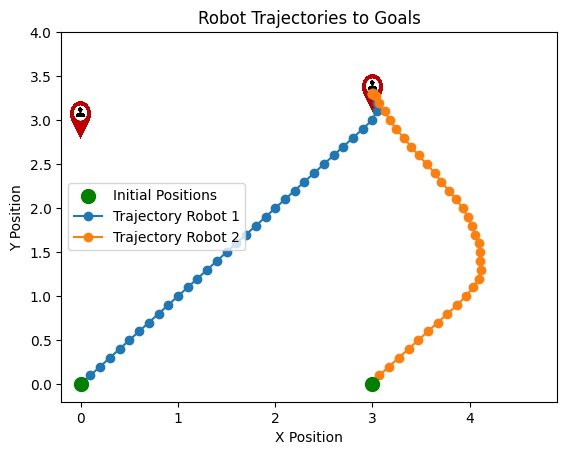

In [29]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import time

def plot_trajectories(trajectories, goals, x_init, not_completed_task_img):
    fig, ax = plt.subplots()
    ax.scatter(x_init[:, 0], x_init[:, 1], marker='o', color='green', label='Initial Positions', s=100, zorder=3)
    
    num_agents = trajectories.shape[1]
    for i in range(num_agents):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], marker='o', label=f'Trajectory Robot {i+1}')
    
    # Load task icons
    not_completed_task_img = OffsetImage(not_completed_task_img, zoom=0.05)
    task_icons = []
    
    # Initialize task icons
    for pos in goals:
        task_icon = AnnotationBbox(not_completed_task_img, pos, frameon=False, zorder=1)
        ax.add_artist(task_icon)
        task_icons.append(task_icon)

    ax.set_title('Robot Trajectories to Goals')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_xlim(-0.2, 4.9)
    ax.set_ylim(-0.2, 4)
    ax.legend(loc='center left')
    plt.pause(0.1)

    time.sleep(1)  # Pause for a short time before next iteration

completed_task_img = mpimg.imread('figures/meeting_icon_not_selected.png')
plot_trajectories(trajectories, goals, initial_state, completed_task_img)
